# Bayesian regression with linear basis function models

This article is an introduction to Bayesian regression with linear basis function models. After a short overview of the relevant mathematical results and their intuition, Bayesian linear regression is implemented from scratch with [NumPy](http://www.numpy.org/) followed by an example how [scikit-learn](https://scikit-learn.org/stable/) can be used to obtain equivalent results. It is assumed that you already have a basic understanding probability distributions and [Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem). For a detailed mathematical coverage I recommend reading chapter 3 of [Pattern Recognition and Machine Learning](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf) (PRML) but this is not necessary for following this article.  

## Linear basis function models

Linear regression models share the property of being linear in their parameters but not necessarily in their input variables. Using non-linear basis functions of input variables, linear models are able model arbitrary non-linearities from input variables to targets. Polynomial regression is such an example and will be demonstrated later. A linear regression model $y(\mathbf{x}, \mathbf{w})$ can therefore be defined more generally as

$$
y(\mathbf{x}, \mathbf{w}) = w_0 + \sum_{j=1}^{M-1}{w_j \phi_j(\mathbf{x})} = \sum_{j=0}^{M-1}{w_j \phi_j(\mathbf{x})} = \mathbf{w}^T \boldsymbol\phi(\mathbf{x}) \tag{1}
$$

where $\phi_j$ are basis functions and $M$ is the total number of parameters $w_j$ including the bias term $w_0$. Here, we use the convention $\phi_0(\mathbf{x}) = 1$. The simplest form of linear regression models are also linear functions of their input variables i.e. the set of basis functions in this case is the identity $\boldsymbol\phi(\mathbf{x}) = \mathbf{x}$. The target variable $t$ of an observation $\mathbf{x}$ is given by a deterministic function $y(\mathbf{x}, \mathbf{w})$ plus additive random noise $\epsilon$. 

$$
t = y(\mathbf{x}, \mathbf{w}) + \epsilon \tag{2}
$$

We make the assumption that the noise is normally distributed i.e. follows a Gaussian distribution with zero mean and precision (= inverse variance) $\beta$. The corresponding probabilistic model i.e. the conditional distribution of $t$ given $\mathbf{x}$ can therefore be written as

$$
p(t \lvert \mathbf{x}, \mathbf{w}, \beta) = 
\mathcal{N}(t \lvert y(\mathbf{x}, \mathbf{w}), \beta^{-1}) =
\sqrt{\beta \over {2 \pi}} \exp\left(-{\beta \over 2} (t - y(\mathbf{x}, \mathbf{w}))^2 \right) \tag{3}
$$

where the mean of this distribution is the regression function $y(\mathbf{x}, \mathbf{w})$. 

## Likelihood function

For fitting the model and for inference of model parameters we use a training set of $N$ independent and identically distributed (i.i.d.) observations $\mathbf{x}_1,\ldots,\mathbf{x}_N$ and their corresponding targets $t_1,\ldots,t_N$. After combining column vectors $\mathbf{x}_i$ into matrix $\mathbf{X}$, where $\mathbf{X}_{i,:} = \mathbf{x}_i^T$, and scalar targets $t_i$ into column vector $\mathbf{t}$ the joint conditional probability of targets $\mathbf{t}$ given $\mathbf{X}$ can be formulated as

$$
p(\mathbf{t} \lvert \mathbf{X}, \mathbf{w}, \beta) = 
\prod_{i=1}^{N}{\mathcal{N}(t_i \lvert \mathbf{w}^T \boldsymbol\phi(\mathbf{x}_i), \beta^{-1})} \tag{4}
$$

This is a function of parameters $\mathbf{w}$ and $\beta$ and is called the *likelihood function*. For better readability, it will be written as $p(\mathbf{t} \lvert \mathbf{w}, \beta)$ instead of $p(\mathbf{t} \lvert \mathbf{X}, \mathbf{w}, \beta)$ from now on. The log of the likelihood function can be written as 

$$
\log p(\mathbf{t} \lvert \mathbf{w}, \beta) = 
{N \over 2} \log \beta - 
{N \over 2} \log {2 \pi} - 
\beta E_D(\mathbf{w}) \tag{5}
$$

where $E_D(\mathbf{w})$ is the sum-of-squares error function coming from the exponent of the likelihood function.

$$
E_D(\mathbf{w}) = 
{1 \over 2} \sum_{i=1}^{N}(t_i - \mathbf{w}^T \boldsymbol\phi(\mathbf{x}_i))^2 = 
{1 \over 2} \lVert \mathbf{t} - \boldsymbol\Phi \mathbf{w} \rVert^2 \tag{6}
$$

Matrix $\boldsymbol\Phi$ is called the *design matrix* and is defined as

$$
\boldsymbol\Phi = 
\begin{pmatrix}
\phi_0(\mathbf{x}_1) &  \phi_1(\mathbf{x}_1) & \cdots & \phi_{M-1}(\mathbf{x}_1) \\ 
\phi_0(\mathbf{x}_2) &  \phi_1(\mathbf{x}_2) & \cdots & \phi_{M-1}(\mathbf{x}_2) \\
\vdots & \vdots & \ddots & \vdots \\
\phi_0(\mathbf{x}_N) &  \phi_1(\mathbf{x}_N) & \cdots & \phi_{M-1}(\mathbf{x}_N)
\end{pmatrix} \tag{7}
$$

## Maximum likelihood

Maximizing the log likelihood (= minimizing the sum-of-squares error function) w.r.t. $\mathbf{w}$ gives the maximum likelihood estimate of parameters $\mathbf{w}$. Maximum likelihood estimation can lead to severe over-fitting if complex models (e.g. polynomial regression models of high order) are fit to datasets of limited size. A common approach to prevent over-fitting is to add a regularization term to the error function. As we will see shortly, this regularization term arises naturally when following a Bayesian approach (more precisely, when defining a prior distribution over parameters $\mathbf{w}$). 

## Bayesian approach

### Prior and posterior distribution

For a Bayesian treatment of linear regression we need a prior probability distribution over model parameters $\mathbf{w}$. For reasons of simplicity, we will use an isotropic Gaussian distribution over parameters $\mathbf{w}$ with zero mean:

$$
p(\mathbf{w} \lvert \alpha) = \mathcal{N}(\mathbf{w} \lvert \mathbf{0}, \alpha^{-1}\mathbf{I}) \tag{8}
$$

An isotropic Gaussian distribution has a diagonal covariance matrix where all diagonal elements have the same variance $\alpha^{-1}$ ($\alpha$ is the precision of the prior). A zero mean favors small(er) values of parameters $w_j$ a priori. The prior is [conjugate](https://en.wikipedia.org/wiki/Conjugate_prior) to the likelihood $p(\mathbf{t} \lvert \mathbf{w}, \beta)$ meaning that the posterior distribution has the same functional form as the prior i.e. is also a Gaussian. In this special case, the posterior has an analytical solution with the following sufficient statistics 

$$
\begin{align*}
\mathbf{m}_N &= \beta \mathbf{S}_N \boldsymbol\Phi^T \mathbf{t}  \tag{9} \\
\mathbf{S}_N^{-1} &= \alpha\mathbf{I} + \beta \boldsymbol\Phi^T \boldsymbol\Phi  \tag{10}
\end{align*}
$$

$(9)$ is the mean vector of the posterior and $(10)$ the inverse covariance matrix (= precision matrix). Hence, the posterior distribution can be written as

$$
p(\mathbf{w} \lvert \mathbf{t}, \alpha, \beta) = \mathcal{N}(\mathbf{w} \lvert \mathbf{m}_N, \mathbf{S}_N) \tag{11}
$$

For the moment, we assume that the values of $\alpha$ and $\beta$ are known. Since the posterior is proportional to the product of likelihood and prior, the log of the posterior distribution is proportional to the sum of the log likelihood and the log of the prior

$$
\log p(\mathbf{w} \lvert \mathbf{t}, \alpha, \beta) = 
-\beta E_D(\mathbf{w}) - \alpha E_W(\mathbf{w}) + \mathrm{const.} \tag{12}
$$

where $E_D(\mathbf{w})$ is defined by $(6)$ and 

$$
E_W(\mathbf{w}) = {1 \over 2} \mathbf{w}^T \mathbf{w} \tag{13}
$$

Maximizing the log posterior w.r.t. $\mathbf{w}$ gives the [maximum-a-posteriori](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) (MAP) estimate of $\mathbf{w}$. Maximizing the log posterior is equivalent to minimizing the sum-of-squares error function $E_D$ plus a quadratic regularization term $E_W$. This particular form regularization is known as *L2 regularization* or *weight decay* as it limits the magnitude of weights $w_j$. The contribution of the regularization term is determined by the ratio $\alpha / \beta$.

### Posterior predictive distribution

For making a prediction $t$ at a new location $\mathbf{x}$ we use the posterior predictive distribution which is defined as

$$
p(t \lvert \mathbf{x}, \mathbf{t}, \alpha, \beta) = 
\int{p(t \lvert \mathbf{x}, \mathbf{w}, \beta) p(\mathbf{w} \lvert \mathbf{t}, \alpha, \beta) d\mathbf{w}} \tag{14}
$$

The posterior predictive distribution includes uncertainty about parameters $\mathbf{w}$ into predictions by weighting the conditional distribution $p(t \lvert \mathbf{x}, \mathbf{w}, \beta)$ with the posterior probability of weights $p(\mathbf{w} \lvert \mathbf{t}, \alpha, \beta)$ over the entire weight parameter space. By using the predictive distribution we're not only getting the expected value of $t$ at a new location $\mathbf{x}$ but also the uncertainty for that prediction. In our special case, the posterior predictive distribution is a Gaussian distribution

$$
p(t \lvert \mathbf{x}, \mathbf{t}, \alpha, \beta) = 
\mathcal{N}(t \lvert \mathbf{m}_N^T \boldsymbol\phi(\mathbf{x}), \sigma_N^2(\mathbf{x})) \tag{15}
$$

where mean $\mathbf{m}_N^T \boldsymbol\phi(\mathbf{x})$ is the regression function after $N$ observations and $\sigma_N^2(\mathbf{x})$ is the corresponding predictive variance

$$
\sigma_N^2(\mathbf{x}) = {1 \over \beta} + \boldsymbol\phi(\mathbf{x})^T \mathbf{S}_N \boldsymbol\phi(\mathbf{x}) \tag{16}
$$

The first term in $(16)$ represents the inherent noise in the data and the second term covers the uncertainty about parameters $\mathbf{w}$. So far, we have assumed that the values of $\alpha$ and $\beta$ are known. In a fully Bayesian treatment, however, we should define priors over $\alpha$ and $\beta$ and use the corresponding posteriors to additionally include uncertainties about $\alpha$ and $\beta$ into predictions. Unfortunately, complete integration over all three parameters $\mathbf{w}$, $\alpha$ and $\beta$ is analytically intractable and we have to use another approach.

### Evidence function

Estimates for $\alpha$ and $\beta$ can alternatively be obtained by first integrating the product of likelihood and prior over parameters $\mathbf{w}$

$$
p(\mathbf{t} \lvert \alpha, \beta) =
\int{p(\mathbf{t} \lvert \mathbf{w}, \beta) p(\mathbf{w} \lvert \alpha) d\mathbf{w}} \tag{17}
$$

and then maximizing the resulting *marginal likelihood* or *evidence function* w.r.t. $\alpha$ and $\beta$. This approach is known as [empirical Bayes](https://en.wikipedia.org/wiki/Empirical_Bayes_method). It can be shown that this is a good approximation for a fully Bayesian treatment if the posterior for $\alpha$ and $\beta$ is sharply peaked around the most probable value and the prior is relatively flat which is often a reasonable assumption. Integrating over model parameters or using a good approximation for it allows us to estimate values for $\alpha$ and $\beta$, and hence the regularization strength $\alpha / \beta$, from training data alone i.e. without using a validation set. 

The log of the marginal likelihood is given by

$$
\log p(\mathbf{t} \lvert \alpha, \beta) = {M \over 2} \log \alpha + {N \over 2} \log \beta -
E(\mathbf{m}_N) - {1 \over 2} \log \lvert \mathbf{S}_N^{-1}\rvert - {N \over 2} \log {2 \pi} \tag{18}
$$

where

$$
E(\mathbf{m}_N) = {\beta \over 2} \lVert \mathbf{t} - \boldsymbol\Phi \mathbf{m}_N \rVert^2 +
{\alpha \over 2} \mathbf{m}_N^T \mathbf{m}_N \tag{19}
$$

For completeness, the relationship between evidence, likelihood, prior, posterior is of course given by Bayes' theorem

$$
p(\mathbf{w} \lvert \mathbf{t}, \alpha, \beta) = 
{p(\mathbf{t} \lvert \mathbf{w}, \beta) p(\mathbf{w} \lvert \alpha) \over p(\mathbf{t} \lvert \alpha, \beta)}  \tag{20}
$$

#### Maximization

Maximization of the log marginal likelihood w.r.t. $\alpha$ and $\beta$ gives the following implicit solutions.

$$
\alpha = {\gamma \over \mathbf{m}_N^T \mathbf{m}_N} \tag{21}
$$

and 

$$
{1 \over \beta} = {1 \over N - \gamma} \sum_{i=1}^{N}(t_i - \mathbf{m}_N^T \boldsymbol\phi(\mathbf{x}_i))^2 \tag{22}
$$

where 

$$
\gamma = \sum_{i=0}^{M-1} {\lambda_i \over \alpha + \lambda_i} \tag{23}
$$


and $\lambda_i$ are the [eigenvalues](https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors) of $\beta \boldsymbol\Phi^T \boldsymbol\Phi$. The solutions are implicit because $\alpha$ and $\gamma$ as well as $\beta$ and $\gamma$ depend on each other. Solutions for $\alpha$ and $\beta$ can therefore be obtained by starting with initial values for these parameters and then iterating over the above equations until convergence.

#### Evaluation

Integration over model parameters also makes models of different complexity directly comparable by evaluating their evidence function on training data alone without needing a validation set. Further below we'll see an example how polynomial models of different complexity (i.e. different polynomial degree) can be compared directly by evaluating their evidence function alone. The highest evidence is usually obtained for models of intermediate complexity i.e. for models whose complexity is just high enough for explaining the data sufficiently well. 

## Implementation

### Posterior and posterior predictive distribution

We start with the implementation of the posterior and posterior predictive distributions. Function `posterior` computes the mean and covariance matrix of the posterior distribution and function `posterior_predictive` computes the mean and the variances of the posterior predictive distribution. Here, readability of code and similarity to the mathematical definitions has higher priority than optimizations.

In [22]:
import numpy as np


def posterior(Phi, t, alpha, beta, return_inverse=False):
    """Computes mean and covariance matrix of the posterior distribution."""
    S_N_inv = alpha * np.eye(Phi.shape[1]) + beta * Phi.T.dot(Phi)
    S_N = np.linalg.inv(S_N_inv)
    m_N = beta * S_N.dot(Phi.T).dot(t)

    if return_inverse:
        return m_N, S_N, S_N_inv
    else:
        return m_N, S_N


def posterior_predictive(Phi_test, m_N, S_N, beta):
    """Computes mean and variances of the posterior predictive distribution."""
    y = Phi_test.dot(m_N)
    # Only compute variances (diagonal elements of covariance matrix)
    y_var = 1 / beta + np.sum(Phi_test.dot(S_N) * Phi_test, axis=1)
    
    return y, y_var

### Example datasets

The datasets used in the following examples are based on $N$ scalar observations $x_{i = 1,\ldots,N}$ which are combined into a $N \times 1$ matrix $\mathbf{X}$. Target values $\mathbf{t}$ are generated from $\mathbf{X}$ with functions `f` and `g` which also generate random noise whose variance can be specified with the `noise_variance` parameter. We will use `f` for generating noisy samples from a straight line and `g` for generating noisy samples from a sinusoidal function.

In [23]:
f_w0 = -0.3
f_w1 =  0.5


def f(X, noise_variance):
    '''Linear function plus noise'''
    return f_w0 + f_w1 * X + noise(X.shape, noise_variance)


def g(X, noise_variance):
    '''Sinusoidial function plus noise'''
    return 0.5 + np.sin(2 * np.pi * X) + noise(X.shape, noise_variance)


def noise(size, variance):
    return np.random.normal(scale=np.sqrt(variance), size=size)

### Basis functions

For straight line fitting, a model that is linear in its input variable $x$ is sufficient. Hence, we don't need to transform $x$ with a basis function which is equivalent to using an `identity_basis_function`. For fitting a linear model to a sinusoidal dataset we transform input $x$ with `gaussian_basis_function` and later with `polynomial_basis_function`. These non-linear basis functions are necessary to model the non-linear relationship between input $x$ and target $t$. The design matrix $\boldsymbol\Phi$ can be computed from observations $\mathbf{X}$ and a parametric basis function with function `expand`. This function also prepends a column vector $\mathbf{1}$ according to $\phi_0(x) = 1$.

In [24]:
def identity_basis_function(x):
    return x


def gaussian_basis_function(x, mu, sigma=0.1):
    return np.exp(-0.5 * (x - mu) ** 2 / sigma ** 2)


def polynomial_basis_function(x, power):
    return x ** power


def expand(x, bf, bf_args=None):
    if bf_args is None:
        return np.concatenate([np.ones(x.shape), bf(x)], axis=1)
    else:
        return np.concatenate([np.ones(x.shape)] + [bf(x, bf_arg) for bf_arg in bf_args], axis=1)

### Straight line fitting

For straight line fitting, we use a linear regression model of the form $y(x, \mathbf{w}) = w_0 + w_1 x$ and do Bayesian inference for model parameters $\mathbf{w}$. Predictions are made with the posterior predictive distribution. Since this model has only two parameters, $w_0$ and $w_1$, we can visualize the posterior density in 2D which is done in the first column of the following output. Rows use an increasing number of training data from a training dataset.

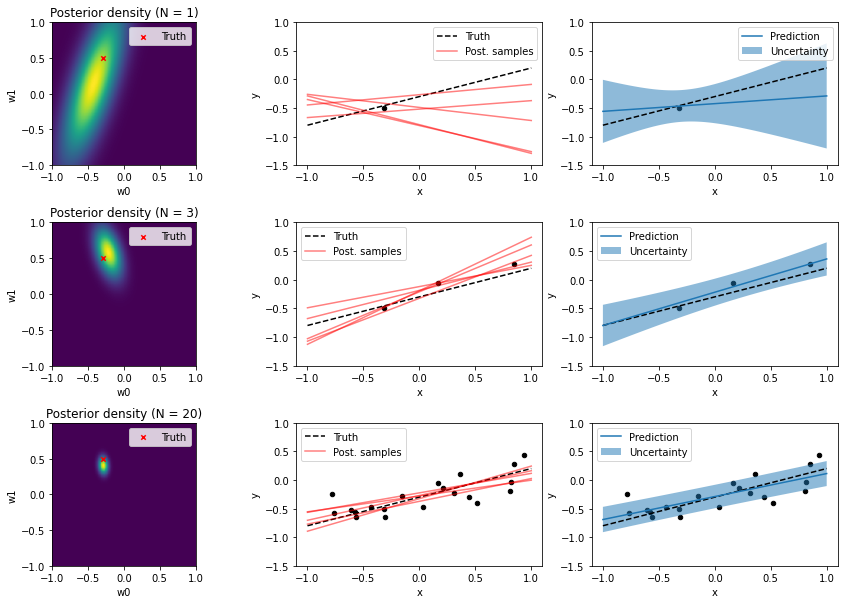

In [25]:
from bayesian_linear_regression_util import *

import matplotlib.pyplot as plt
%matplotlib inline

# Training dataset sizes
N_list = [1, 3, 20]

beta = 25.0
alpha = 2.0

# Training observations in [-1, 1)
X = np.random.rand(N_list[-1], 1) * 2 - 1

# Training target values
t = f(X, noise_variance=1/beta)

# Test observations
X_test = np.linspace(-1, 1, 100).reshape(-1, 1)

# Function values without noise 
y_true = f(X_test, noise_variance=0)
    
# Design matrix of test observations
Phi_test = expand(X_test, identity_basis_function)

plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.4)

for i, N in enumerate(N_list):
    X_N = X[:N]
    t_N = t[:N]

    # Design matrix of training observations
    Phi_N = expand(X_N, identity_basis_function)
    
    # Mean and covariance matrix of posterior
    m_N, S_N = posterior(Phi_N, t_N, alpha, beta)
    
    # Mean and variances of posterior predictive 
    y, y_var = posterior_predictive(Phi_test, m_N, S_N, beta)
    
    # Draw 5 random weight samples from posterior and compute y values
    w_samples = np.random.multivariate_normal(m_N.ravel(), S_N, 5).T
    y_samples = Phi_test.dot(w_samples)
    
    plt.subplot(len(N_list), 3, i * 3 + 1)
    plot_posterior(m_N, S_N, f_w0, f_w1)
    plt.title(f'Posterior density (N = {N})')
    plt.legend()

    plt.subplot(len(N_list), 3, i * 3 + 2)
    plot_data(X_N, t_N)
    plot_truth(X_test, y_true)
    plot_posterior_samples(X_test, y_samples)
    plt.ylim(-1.5, 1.0)
    plt.legend()

    plt.subplot(len(N_list), 3, i * 3 + 3)
    plot_data(X_N, t_N)
    plot_truth(X_test, y_true, label=None)
    plot_predictive(X_test, y, np.sqrt(y_var))
    plt.ylim(-1.5, 1.0)
    plt.legend()

In the second column, 5 random weight samples are drawn from the posterior and the corresponding regression lines are plotted in red color. The line resulting from the true parameters, `f_w0` and `f_w1` is plotted as dashed black line and the noisy training data as black dots. The third column shows the mean and the standard deviation of the posterior predictive distribution along with the true model and the training data.

It can be clearly seen how the posterior density in the first column gets more sharply peaked as the size of the dataset increases which corresponds to a decrease in the sample variance in the second column and to a decrease in prediction uncertainty as shown in the third column. Also note how prediction uncertainty is higher in regions of less observations. 

### Gaussian basis functions

The following example demonstrates how to fit a Gaussian basis function model to a noisy sinusoidal dataset. It uses 9 Gaussian basis functions with mean values equally distributed over $[0, 1]$ each having a standard deviation of $0.1$. Inference for parameters $\mathbf{w}$ is done in the same way as in the previous example except that we now infer values for 10 parameters (bias term $w_0$ and $w_1,\ldots,w_9$ for the 9 basis functions) instead of 2. We therefore cannot display the posterior density unless we selected 2 parameters at random.

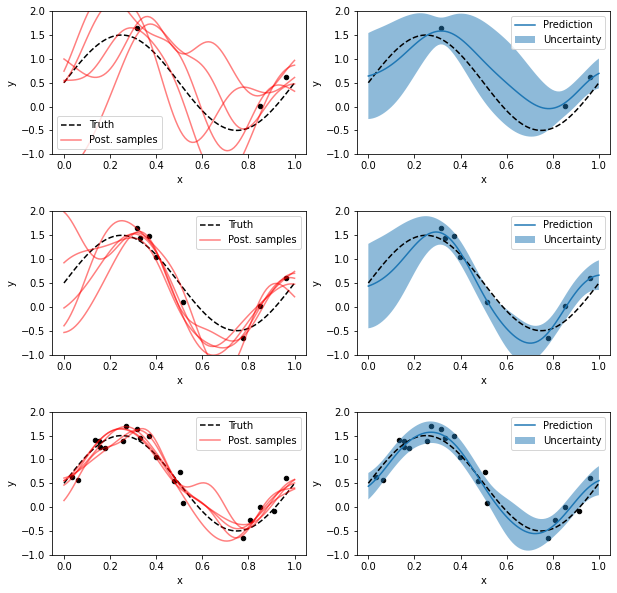

In [26]:
N_list = [3, 8, 20]

beta = 25.0
alpha = 2.0

# Training observations in [-1, 1)
X = np.random.rand(N_list[-1], 1)

# Training target values
t = g(X, noise_variance=1/beta)

# Test observations
X_test = np.linspace(0, 1, 100).reshape(-1, 1)

# Function values without noise 
y_true = g(X_test, noise_variance=0)
    
# Design matrix of test observations
Phi_test = expand(X_test, bf=gaussian_basis_function, bf_args=np.linspace(0, 1, 9))

plt.figure(figsize=(10, 10))
plt.subplots_adjust(hspace=0.4)

for i, N in enumerate(N_list):
    X_N = X[:N]
    t_N = t[:N]

    # Design matrix of training observations
    Phi_N = expand(X_N, bf=gaussian_basis_function, bf_args=np.linspace(0, 1, 9))

    # Mean and covariance matrix of posterior
    m_N, S_N = posterior(Phi_N, t_N, alpha, beta)
    
    # Mean and variances of posterior predictive 
    y, y_var = posterior_predictive(Phi_test, m_N, S_N, beta)
    
    # Draw 5 random weight samples from posterior and compute y values
    w_samples = np.random.multivariate_normal(m_N.ravel(), S_N, 5).T
    y_samples = Phi_test.dot(w_samples)
    
    plt.subplot(len(N_list), 2, i * 2 + 1)
    plot_data(X_N, t_N)
    plot_truth(X_test, y_true)
    plot_posterior_samples(X_test, y_samples)
    plt.ylim(-1.0, 2.0)
    plt.legend()
    
    plt.subplot(len(N_list), 2, i * 2 + 2)
    plot_data(X_N, t_N)
    plot_truth(X_test, y_true, label=None)
    plot_predictive(X_test, y, np.sqrt(y_var))
    plt.ylim(-1.0, 2.0)
    plt.legend()

Again, as the size of the dataset increases the posterior sample variance and the prediction uncertainty decreases. Also, regions with less observations have higher prediction uncertainty.

### Evidence evaluation

As already mentioned, the evidence function or marginal likelihood can be used to compare models of different complexity using training data alone. This is shown here for 10 polynomial basis function models of different degree using a sinusoidal dataset generated with `g`. For evaluating the log marginal likelihood we implement $(18)$ as `log_marginal_likelihood` function. 

In [33]:
def log_marginal_likelihood(Phi, t, alpha, beta):
    """Computes the log of the marginal likelihood."""
    N, M = Phi.shape
    print(N, M)
    m_N, _, S_N_inv = posterior(Phi, t, alpha, beta, return_inverse=True)
    
    E_D = beta * np.sum((t - Phi.dot(m_N)) ** 2)
    E_W = alpha * np.sum(m_N ** 2)

    score = M * np.log(alpha) + \
            N * np.log(beta) - \
            E_D - \
            E_W - \
            np.log(np.linalg.det(S_N_inv)) - \
            N * np.log(2 * np.pi)

    return 0.5 * score

The 10 polynomial basis function models of degrees 0-9 are compared based on the log marginal likelihood computed with a dataset of 10 observations. We still assume that the values of $\alpha$ and $\beta$ are known and will see in the next section how they can be inferred by maximizing the log marginal likelihood. When plotting the posterior predictive distribution of the polynomial models we can see that a model of degree 3 has already sufficient complexity to explain the data reasonably well.

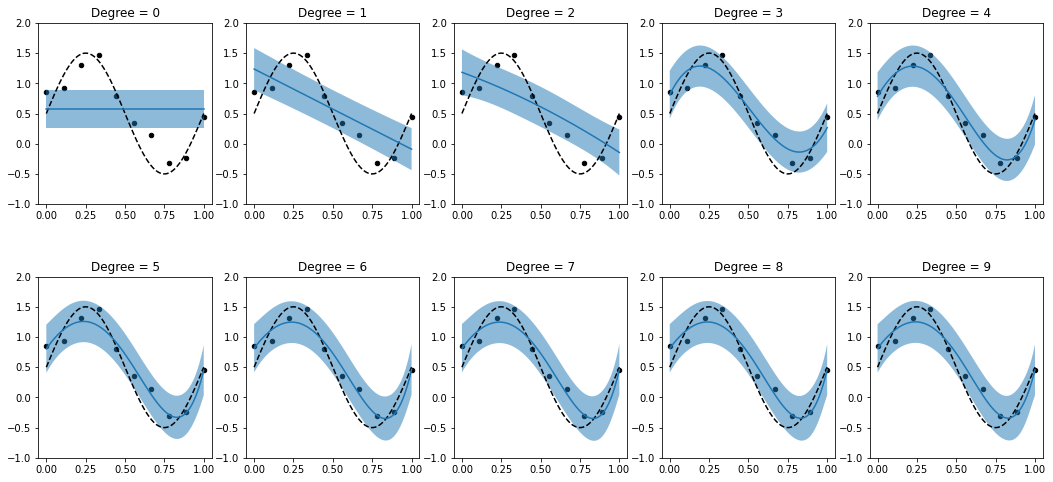

In [34]:
N = 10

beta = 1 / (0.3 ** 2)
alpha = 0.005

degree = 9
degrees = range(degree + 1)

X = np.linspace(0, 1, N).reshape(-1, 1)
t = g(X, noise_variance=1/beta)

Phi = expand(X, bf=polynomial_basis_function, bf_args=degrees[1:])
Phi_test = expand(X_test, bf=polynomial_basis_function, bf_args=degrees[1:])

plt.figure(figsize=(18, 8))
plt.subplots_adjust(hspace=0.4)

for d in degrees:
    up = d + 1
    m_N, S_N = posterior(Phi[:,:up], t, alpha, beta)
    y, y_var = posterior_predictive(Phi_test[:,:up], m_N, S_N, beta)

    plt.subplot(2, 5, up)
    plot_data(X, t)
    plot_truth(X_test, y_true, label=None)
    plot_predictive(X_test, y, np.sqrt(y_var), y_label=None, std_label=None, plot_xy_labels=False)
    plt.title(f'Degree = {d}')
    plt.ylim(-1.0, 2.0)

We also see how polynomial models of higher degree do not overfit to the dataset which is a consequence of using a prior over model parameters that favors small(er) parameter values. This is equivalent to minimizing a sum-of-squares error function plus a quadratic regularization term whose strength is given by ratio $\alpha / \beta$ as can be seen from equation $(12)$. 

When evaluating the log marginal likelihood for all 10 polynomial models we usually obtain the highest value for models of degree 3 or 4 (depending on the non-deterministic part i.e. noise of the generated dataset results may vary slightly). This is consistent with the observation that a polynomial model of degree 3 already explains the data sufficiently well and confirms that marginal likelihood evaluation favors models of intermediate complexity.

10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10


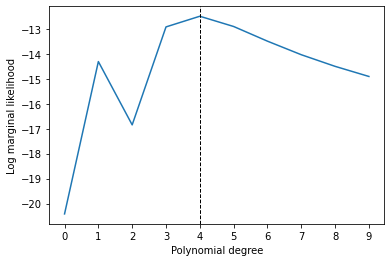

In [35]:
mlls = []

for d in degrees:
    mll = log_marginal_likelihood(Phi[:,:d+1], t, alpha=alpha, beta=beta)
    mlls.append(mll)

degree_max = np.argmax(mlls)
    
plt.plot(degrees, mlls)
plt.axvline(x=degree_max, ls='--', c='k', lw=1)
plt.xticks(range(0, 10))
plt.xlabel('Polynomial degree')
plt.ylabel('Log marginal likelihood');

It is also interesting to see that a polynomial model of degree 1 (straight line) seems to explain the data better than a model of degree 2. This is because the data-generating sinusoidal function has no even terms in a polynomial expansion. A model of degree 2 therefore only adds complexity without being able to explain the data better. This higher complexity is penalized by the evidence function (see also section 3.4. in [PRML](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf)).

### Evidence maximization

So far we have assumed that values of $\alpha$ and $\beta$ are known. In most situations however, they are unknown and must be inferred. Iterating over equations $(21)$ and $(22)$ until convergence jointly infers the posterior distribution over parameters $\mathbf{w}$ and optimal values for parameters $\alpha$ and $\beta$. This is implemented in the following `fit` function. We start with small values for $\alpha$ and $\beta$ corresponding to a low precision (= high variance) of prior $(8)$ and conditional density $(3)$.

In [30]:
def fit(Phi, t, alpha_0=1e-5, beta_0=1e-5, max_iter=200, rtol=1e-5, verbose=False):
    """
    Jointly infers the posterior sufficient statistics and optimal values 
    for alpha and beta by maximizing the log marginal likelihood.
    
    Args:
        Phi: Design matrix (N x M).
        t: Target value array (N x 1).
        alpha_0: Initial value for alpha.
        beta_0: Initial value for beta.
        max_iter: Maximum number of iterations.
        rtol: Convergence criterion.
        
    Returns:
        alpha, beta, posterior mean, posterior covariance.
    """
    
    N, M = Phi.shape

    eigenvalues_0 = np.linalg.eigvalsh(Phi.T.dot(Phi))

    beta = beta_0
    alpha = alpha_0

    for i in range(max_iter):
        beta_prev = beta
        alpha_prev = alpha

        eigenvalues = eigenvalues_0 * beta

        m_N, S_N, S_N_inv = posterior(Phi, t, alpha, beta, return_inverse=True)

        gamma = np.sum(eigenvalues / (eigenvalues + alpha))
        alpha = gamma / np.sum(m_N ** 2)

        beta_inv = 1 / (N - gamma) * np.sum((t - Phi.dot(m_N)) ** 2)
        beta = 1 / beta_inv

        if np.isclose(alpha_prev, alpha, rtol=rtol) and np.isclose(beta_prev, beta, rtol=rtol):
            if verbose:
                print(f'Convergence after {i + 1} iterations.')
            return alpha, beta, m_N, S_N

    if verbose:
        print(f'Stopped after {max_iter} iterations.')
    return alpha, beta, m_N, S_N

We now generate a sinusoidal training dataset of size 30 with variance $\beta^{-1} = 0.3^2$ and then use `fit` to obtain the posterior over parameters $\mathbf{w}$ and optimal values for $\alpha$ and $\beta$. The used regression model is a polynomial model of degree 4.

In [31]:
N = 30

degree = 4

X = np.linspace(0, 1, N).reshape(-1, 1)
t = g(X, noise_variance=0.3 ** 2)

Phi = expand(X, bf=polynomial_basis_function, bf_args=range(1, degree + 1))

alpha, beta, m_N, S_N = fit(Phi, t, rtol=1e-5, verbose=True)

Convergence after 35 iterations.


Alternatively, we can also use [`BayesianRidge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html#sklearn.linear_model.BayesianRidge) from scikit-learn for Bayesian regression. The `fit` and `predict` methods of this estimator are on the same abstraction level as our `fit` and `posterior_predictive` functions. The implementation of `BayesianRidge` is very similar to our implementation except that it uses [Gamma](https://en.wikipedia.org/wiki/Gamma_distribution) priors over parameters $\alpha$ and $\beta$. The default hyper-parameter values of the Gamma priors assign high probability density to low values for $\alpha$ and $\beta$. In our implementation, we simply start optimization from low $\alpha$ and $\beta$ values. Another difference is that `BayesianRidge` uses different parameter names (`lambda` instead of `alpha` and `alpha` instead of `beta`, see also section [Bayesian Regression](https://scikit-learn.org/stable/modules/linear_model.html#bayesian-regression) in the scikit-learn user guide).

In [32]:
from sklearn.linear_model import BayesianRidge

br = BayesianRidge(fit_intercept=False, tol=1e-5, verbose=True)
br.fit(Phi, t.ravel());

ModuleNotFoundError: No module named 'sklearn'

When comparing the results from our implementation with those from `BayesianRidge` we see that they are almost identical. In the following, inferred values for $\alpha$, $\beta$ and $\mathbf{m}_N$ are compared as well as predictions and their uncertainties. Results prefixed with `np` are those from our implementation, results prefixed with `br` are those obtained with `BayesianRidge`.

In [ ]:
print_comparison('Alpha', alpha, br.lambda_)

In [ ]:
print_comparison('Beta', beta, br.alpha_)

In [ ]:
print_comparison('Weights', m_N.ravel(), br.coef_)

In [ ]:
# Test values at x = 0.3 and x = 0.7 
X_test = np.array([[0.3], [0.7]])

# Design matrix of test values
Phi_test = expand(X_test, bf=polynomial_basis_function, bf_args=range(1, degree + 1))

In [ ]:
y_np_mean, y_np_var = posterior_predictive(Phi_test, m_N, S_N, beta)
y_br_mean, y_br_std = br.predict(Phi_test, return_std=True)

print_comparison('Prediction mean', y_np_mean.ravel(), y_br_mean)
print_comparison('Prediction std', np.sqrt(y_np_var), y_br_std)

An alternative, non-parametric approach to Bayesian regression are [Gaussian processes](http://krasserm.github.io/2018/03/19/gaussian-processes/) which infer distributions over functions directly instead of distributions over parameters of parametric models.